In [174]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression 

import matplotlib.pyplot as plt

https://www.nba.com/news/teams-allowed-to-carry-15-players-on-active-roster-for-2020-21-season
It's standard to have 15 players on the roster while 13 are "active". Active means they are allowed to play. For most of the seasons in our dataset, there will be a maximum of 13 players per team per game. Therefore, we will have 13 home player columns and 13 away player columns. 



# Why we can't use a simple home/away df; original and wrong idea in italics

The idea, as explained below, was to have 26 columns (13 home players and 13 away players). This does not work. Why? Well, if the first feature is `home_player_1`, how do we determine who `player_1` is? We have 30 teams and approximately 450 players. While we could assign the "best" player to the first slot, second "best" player to the second slot, and so on, we would still need a model of which players are best on a team. That's its own challenge. Therefore, it's not feasible to run a regression on data where our features are something like arbitrary `home_player_1` because we have to determine which player (and their associated statistic) are assigned to which slot.

The next idea would be to use a sparse matrix. There are 1230 games in a season. Each player will play up to 82 games themselves. We could create a sparse 1230 X 450 matrix where each row is a game and each column represents a player. Each cell will equal 1 if the player plays in the game and 0 otherwise. We would create a second 

### Prior incorrect logic:

*We want to make a dataframe where the outcome is a game's outcome. This will be an integer. We will measure the outcome relative to the home team. If the home team wins by 5, the outcome will be 5. If the home team loses by 5, the outcome will be -5. Our features/explanatory variables are player attributes. We will have 13 home players and 13 away players which gives us 26 features. For each player, we will have a summary statistic*

In [11]:
num_samples = 100
# This is a random game outcome from -20 to 20
example_dict = {"outcome": np.random.randint(-20, 20, num_samples)}

# We are assigning each player a "statistic" with mean 15 and standard deviation 5
# This might be points per game or Player Efficiency Rating (PER, a statistic to
# evaulate player value that always has mean=15)
home_player_dict = {f"h_player_{i}": 
                    list(np.random.normal(loc=15, scale= 5, size=num_samples))
                    for i in range(13)}
away_player_dict = {f"a_player_{i}": 
                    list(np.random.normal(loc=15, scale= 5, size=num_samples))
                    for i in range(13)}
example_dict.update(home_player_dict)
example_dict.update(away_player_dict)

df = pd.DataFrame(example_dict)
print(df.head())
print(df.columns)

   outcome  h_player_0  h_player_1  ...  a_player_10  a_player_11  a_player_12
0      -19   16.278842   16.604691  ...    20.024423    17.046758     9.106622
1        7   13.714399   19.799698  ...     6.990646    12.259402    10.659610
2      -14   14.213070   11.646880  ...    19.008771    18.435637    18.888183
3       16   12.492470   13.150502  ...    20.562685    18.700522    16.204625
4       18   19.807162   10.389774  ...    24.530137    14.362981    18.810905

[5 rows x 27 columns]
Index(['outcome', 'h_player_0', 'h_player_1', 'h_player_2', 'h_player_3',
       'h_player_4', 'h_player_5', 'h_player_6', 'h_player_7', 'h_player_8',
       'h_player_9', 'h_player_10', 'h_player_11', 'h_player_12', 'a_player_0',
       'a_player_1', 'a_player_2', 'a_player_3', 'a_player_4', 'a_player_5',
       'a_player_6', 'a_player_7', 'a_player_8', 'a_player_9', 'a_player_10',
       'a_player_11', 'a_player_12'],
      dtype='object')


In [24]:
# Run a simple regression on the simulated data
X = df.loc[:, df.columns != "outcome"]
y = df.loc[:, df.columns == "outcome"]

model = LinearRegression()
model.fit(X,y) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Reasoning about sparse matrix models
Below, I create a hypothetical sparse matrix of 100 games times 100 players and their associated statistic (points per game, PER, etc.). This would create a dataset where a player's statistic is input into a regression when they play in a game and input 0 when they do not play. 

However, what happens when we have games over multiple seasons? There are 450 roster spots in the NBA. Those roster spots are filled by different players over the course of a season. Let's assume 500 players are on a roster over the course of a season. Each season, some proportion of those roster spots turn over (just as the roster spots change *within* a season). Let's assume 50% of roster spots turn over each season. If we run the regression on 15 seasons from 2004-2019, we'll have 1230 games per season X 15 seasons = 18450 rows/games in our dataset. As for the columns, we will add 0.5 X 500=250 new players each season. We have 500 players in season one. Our number of columns is then 500 + (250 X 14) = 4000 columns. So, we would have a sparse matrix with dimension 18450 X 4000. We could feasibly run a regression on this. We would just find that a maximum of 26 players out of 4000 are relevant for any given row in the data frame.

There are players who only play a few games in the NBA and never again.
A natural way to deal with this is dimensionality reduction via something like PCA or just run a LASSO/Ridge regression which will drive coefficients to zero. This will let us drop these players who don't have much impact. This would seem like a good solution!

However, consider a player on retires in our first season(2004). That player would have statistics in the first 1230 rows (the 1st season) of the data frame. After that, they have no impact. The same effect occurs for a player who's first season is 2019. Both these player types only play in one season. What if these players are important in the one season they play in? Since they're only present in one season, our dimensionality reduction might drop them from the data! 

After thinking through this, I am inclined to say that a sparse matrix is not suitable for our project since we need to use dimensionality reduction, and it would be difficult to disambiguate between a player who is important but plays few games versus an unimportant player.

In [28]:
# 100 game x 100 player matrix of 1's and 0's indicating rather a player played in a game 
play_matrix = np.array([np.round(np.random.sample(100)) for i in range(100)])

# Random statistic for 100 players
stat_vector = np.array(np.random.normal(15, 5, 100))

# A matrix which takes a player's statistic if they played in a game and 0 
# otherwise 
stat_matrix = play_matrix * stat_vector
stat_matrix

array([[12.32805697, 19.35998238, 19.15919016, ...,  0.        ,
        10.17050422,  0.        ],
       [12.32805697, 19.35998238, 19.15919016, ...,  0.        ,
         0.        , 15.39231945],
       [12.32805697,  0.        , 19.15919016, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        10.17050422,  0.        ],
       [ 0.        , 19.35998238,  0.        , ...,  0.        ,
        10.17050422, 15.39231945]])

# Aggregate Player Statistics to Team level

Ok, so we can't use an abstract `home_player_1` and we can't use every single player in a sparse matrix model, but we still want to predict games using player stats! Can we aggregate player statistics to get a set of team level statistics? Let's see how that might work.

In [62]:
# career_avg_min = a player's career average minutes
# pp_36 = points per 36 minutes
# Team = a players team

# We'll create a dataframe of 60 players (four teams worth)
team_spots = ['team_a' for _ in range(15)] + ["team_b" for _ in range(15)] + ["team_c" for _ in range(15)] + ["team_d" for _ in range(15)]
player_dict = {"career_avg_min": [], 'pp_36': [], "team": [], "player_id":[]}

counter = 0
for i in team_spots:
  player_dict['player_id'].append(counter)
  player_dict['team'].append(i)
  player_dict['pp_36'].append(np.random.normal(15, 5))
  player_dict['career_avg_min'].append(np.random.normal(24, 6))
  counter += 1

player_df = pd.DataFrame(player_dict)
player_df.describe()

,career_avg_min,pp_36,player_id
count,60.000000,60.000000,60.000000
mean,24.347112,15.548575,29.500000
std,7.249301,4.209859,17.464249
min,8.348791,5.859841,0.000000
25%,19.024239,12.223649,14.750000
50%,24.282297,15.531554,29.500000
75%,29.181531,19.101227,44.250000
max,49.537614,25.195910,59.000000


In [63]:
# Sum minutes by player. Then, divide 480 by the computed sum. This gives us 
# the ratio of minutes played to minutes in a game
player_sums = player_df.groupby(player_df.team).sum()
player_sums['minute_normalize_ratio'] = 480/player_sums['career_avg_min']
player_sums
player_df['normalized_minutes'] = 0

# For each team, multiply the players minutes by the normalized minutes ratio
# The sum of normalized minutes will equal 480 per team
for team in player_sums.index:
  player_df.loc[player_df.team ==team, 'normalized_minutes'] = player_df.loc[player_df.team == team, 'career_avg_min'] * player_sums.loc[team, 'minute_normalize_ratio']

# Show that we have 480 minutes by team (a full game's worth of minutes)
player_df.groupby(player_df.team).sum()

,career_avg_min,pp_36,player_id,normalized_minutes
team,,,,
team_a,353.813058,229.982084,105,480.0
team_b,401.246348,243.698850,330,480.0
team_c,345.485903,228.214063,555,480.0
team_d,360.281381,231.019484,780,480.0


In [65]:
# Now, we modify the pp_36 column by the amount of minutes a player plays
# if there pp_36 value equals 20, but the player only plays 18 minutes, then
# they will have an estimated points value of 10
player_df['estimated_points'] = player_df['pp_36'] * (player_df['normalized_minutes']/36)
player_df.head()

,career_avg_min,pp_36,team,player_id,normalized_minutes,estimated_points
0,19.115314,18.026062,team_a,0,25.932764,12.985156
1,21.787057,15.412280,team_a,1,29.557382,12.654073
2,20.072836,16.480897,team_a,2,27.231786,12.466785
3,34.135279,10.252289,team_a,3,46.309580,13.188312
4,18.582567,17.214048,team_a,4,25.210014,12.054622


In [98]:
# Now, we want to aggregate the estimated_points to the team level.
# Our dataframe now contains our predictive feature, estimated_points, by team
# which is aggregrated from the player level 
team_df = player_df.groupby("team").sum("estimated_points")
team_df['team'] = team_df.index.to_list()
team_df.index= range(4)
team_df

,career_avg_min,pp_36,player_id,normalized_minutes,estimated_points,team
0,353.813058,229.982084,105,480.0,196.716852,team_a
1,401.246348,243.698850,330,480.0,214.694134,team_b
2,345.485903,228.214063,555,480.0,204.372155,team_c
3,360.281381,231.019484,780,480.0,207.681280,team_d


In [171]:
# Now, we need to create a matchup dataframe between home and away teams. Let's
# have each team play nine home games and nine away games (team a plays team b 
# three time at home and three times away). We'll throw a little noise into 
# the statistics to reflect how the actual dataset might change

# This is just a bunch of code to make a dataframe. Just look at the result

matchup_df = pd.DataFrame({"home_team": ["" for _ in range(9*4)],
                           "away_team": ["" for _ in range(9*4)],
                           "home_statistic": [0 for _ in range(9*4)],
                           "away_statistic": [0 for _ in range(9*4)]})

start_idx = 0
end_idx = 0 
possible_teams_set = set(team_df['team'])
for i in range(0, len(matchup_df)+1, 9):
  end_idx = i+9  
  home_team_idx = int((i/9))
  if home_team_idx < len(team_df):
    home_team = team_df.loc[home_team_idx, "team"]
  # print("i:", i, "home_idx:",home_team_idx, "start_idx:", start_idx, "end_idx:", end_idx)
  matchup_df.loc[start_idx:end_idx, 'home_team'] = home_team

  home_stat = float(team_df.loc[team_df.team == home_team, "estimated_points"])
  matchup_df.loc[start_idx:end_idx, 'home_statistic'] = home_stat

  home_tm_set = set((home_team, ))
  away_teams = list(possible_teams_set.difference(home_tm_set))
  for i in range(0, len(away_teams)):
    away_team = away_teams[i]
    away_stat = float(team_df.loc[team_df.team==away_team, 'estimated_points'])
    # print(away_stat)
    if i == 0:
      matchup_df.loc[start_idx: start_idx+3, "away_team"] = away_team
      matchup_df.loc[start_idx: start_idx+3, "away_statistic"] = away_stat
    else:
      idx_diff = i*3
      start = start_idx +idx_diff
      end = start_idx + idx_diff + 3
      matchup_df.loc[start:end, 'away_team'] = away_team
      matchup_df.loc[start:end, "away_statistic"] = away_stat
  start_idx = end_idx  

matchup_df['home_statistic'] = matchup_df.home_statistic + np.random.normal(loc=0,
                                                scale=np.var(matchup_df.home_statistic), size=len(matchup_df))
matchup_df['away_statistic'] = matchup_df.away_statistic + np.random.normal(loc=0,
                                                scale=np.var(matchup_df.away_statistic), size=len(matchup_df))
matchup_df['outcome'] = matchup_df['home_statistic'] - matchup_df['away_statistic'] + np.random.normal(loc=0, scale=1, size=len(matchup_df))
matchup_df


,home_team,away_team,home_statistic,away_statistic,outcome
0,team_a,team_c,163.022270,191.181030,-26.838023
1,team_a,team_c,145.086159,215.258444,-72.413433
2,team_a,team_c,242.288086,160.109712,81.288567
3,team_a,team_b,192.277936,147.305903,43.781227
4,team_a,team_b,148.873704,270.367568,-122.343277
5,team_a,team_b,234.606028,277.283164,-41.846664
6,team_a,team_d,150.047940,264.935964,-115.401729
7,team_a,team_d,179.083061,194.368216,-15.070740
8,team_a,team_d,234.831572,221.181445,14.615060
9,team_b,team_c,256.431402,166.942500,89.885024


Text(0, 0.5, 'true')

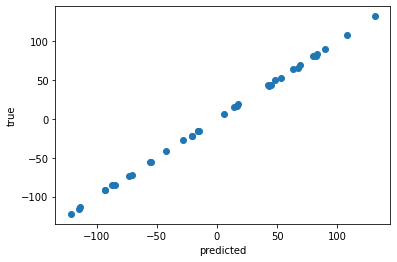

In [179]:
X, y = matchup_df[['home_statistic', 'away_statistic']], matchup_df['outcome']
mod = LinearRegression()
mod.fit(X,y)
pred = mod.predict(X)
plt.plot(pred, y, 'o')
plt.xlabel('predicted')
plt.ylabel('true')

# Conclusion
Ok, so there's an example of how we can agglomerate player level data into team data. I think this is the path to go. 